In [212]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
from pprint import pformat

from hloc import extract_features, match_features, parse_matches, visualization

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Pipeline for indoor localization

## Setup
Here we declare the paths to the dataset, image pairs, and we choose the feature extractor and the matcher. You need to download the dataser and put it in `datasets/<dataset_name>/`, or change the path.

In [213]:
dataset_name = 'room'

dataset = Path(f'datasets/{dataset_name}/')  # change this if your dataset is somewhere else

pairs = Path(f'pairs/{dataset_name}/')
loc_pairs = pairs / 'pairs-query.txt'  # top 40 retrieved by NetVLAD

outputs = Path(f'outputs/{dataset_name}/')  # where everything will be saved
results = outputs / f'{dataset_name}_superpoint+superglue.txt'  # the result file

In [214]:
# list the standard configurations available
print(f'Configs for feature extractors:\n{pformat(extract_features.confs)}')
print(f'Configs for feature matchers:\n{pformat(match_features.confs)}')

Configs for feature extractors:
{'d2net-ss': {'model': {'multiscale': False, 'name': 'd2net'},
              'output': 'feats-d2net-ss',
              'preprocessing': {'grayscale': False, 'resize_max': 1600}},
 'dir': {'model': {'name': 'dir'},
         'output': 'global-feats-dir',
         'preprocessing': {'resize_max': 1024}},
 'netvlad': {'model': {'name': 'netvlad'},
             'output': 'global-feats-netvlad',
             'preprocessing': {'resize_max': 1024}},
 'r2d2': {'model': {'max_keypoints': 5000, 'name': 'r2d2'},
          'output': 'feats-r2d2-n5000-r1024',
          'preprocessing': {'grayscale': False, 'resize_max': 1024}},
 'sift': {'model': {'name': 'sift'},
          'output': 'feats-sift',
          'preprocessing': {'grayscale': True, 'resize_max': 1600}},
 'superpoint_aachen': {'model': {'max_keypoints': 4096,
                                 'name': 'superpoint',
                                 'nms_radius': 3},
                       'output': 'feats-super

In [215]:
# pick one of the configurations for extraction and matching
# you can also simply write your own here!
feature_conf = extract_features.confs['superpoint_inloc']
matcher_conf = match_features.confs['superglue']

## Extract local features for database and query images

In [216]:
feature_path = extract_features.main(feature_conf, dataset, outputs)

[12/16/2021 19:12:33 INFO] Extracting local features with configuration:
{'model': {'max_keypoints': 4096, 'name': 'superpoint', 'nms_radius': 4},
 'output': 'feats-superpoint-n4096-r1600',
 'preprocessing': {'grayscale': True, 'resize_max': 1600}}
[12/16/2021 19:12:33 INFO] Found 10 images in root datasets/room.
Loaded SuperPoint model


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:21<00:00,  2.13s/it]

[12/16/2021 19:12:54 INFO] Finished exporting features.


## Match the query images
Here we assume that the localization pairs are already computed using image retrieval (NetVLAD). To generate new pairs from your own global descriptors, have a look at `hloc/pairs_from_retrieval.py`. These pairs are also used for the localization - see below.

In [217]:
match_path = match_features.main(matcher_conf, loc_pairs, feature_conf['output'], outputs)

[12/16/2021 19:12:54 INFO] Matching local features with configuration:
{'model': {'name': 'superglue', 'sinkhorn_iterations': 50, 'weights': 'indoor'},
 'output': 'matches-superglue'}
Loaded SuperGlue model ("indoor" weights)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:44<00:00,  4.96s/it]

[12/16/2021 19:13:39 INFO] Finished exporting matches.


In [218]:
parse_matches.main(
    dataset, loc_pairs, feature_path, match_path, results,
    skip_matches=20)

[12/16/2021 19:13:39 INFO] Starting localization...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.24it/s]

[12/16/2021 19:13:39 INFO] Writing logs to outputs/room/room_superpoint+superglue.txt_logs.pkl...
[12/16/2021 19:13:39 INFO] Done!


## Visualization
We parse the localization logs and for each query image plot matches and inliers with a few database images.

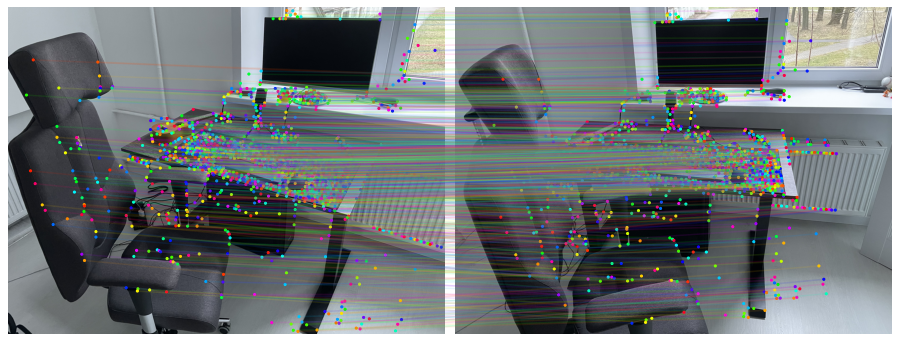

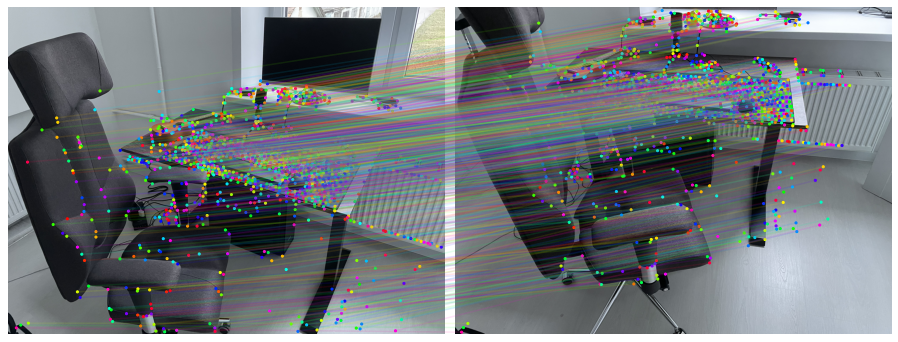

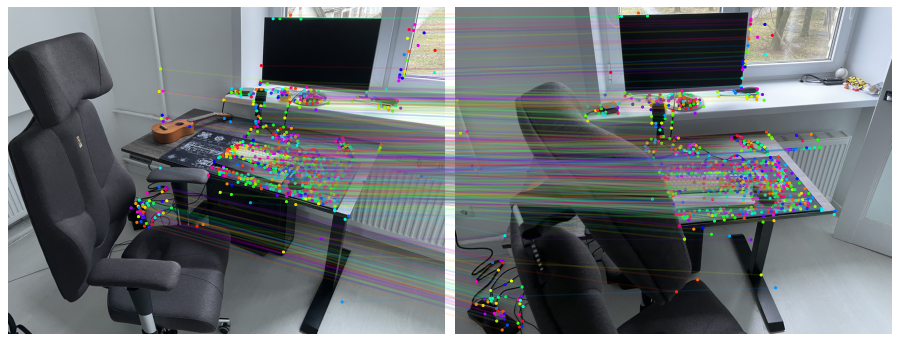

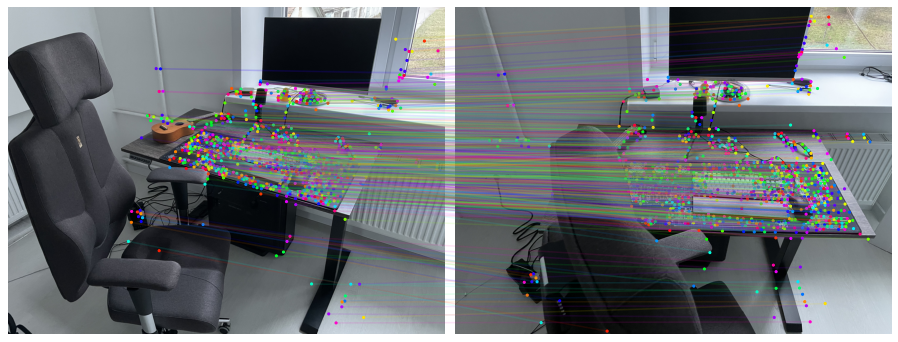

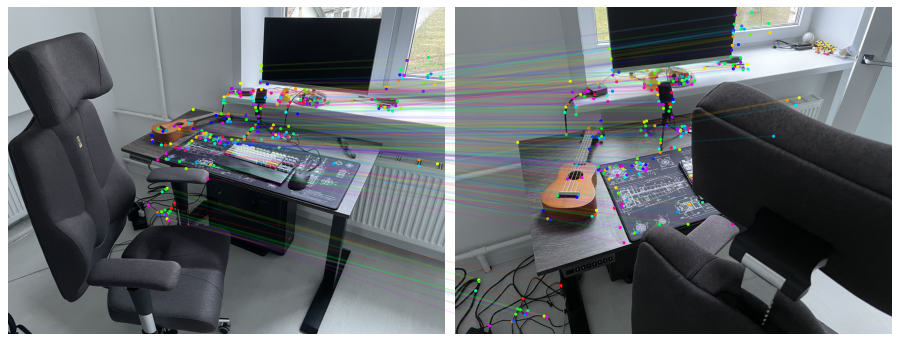

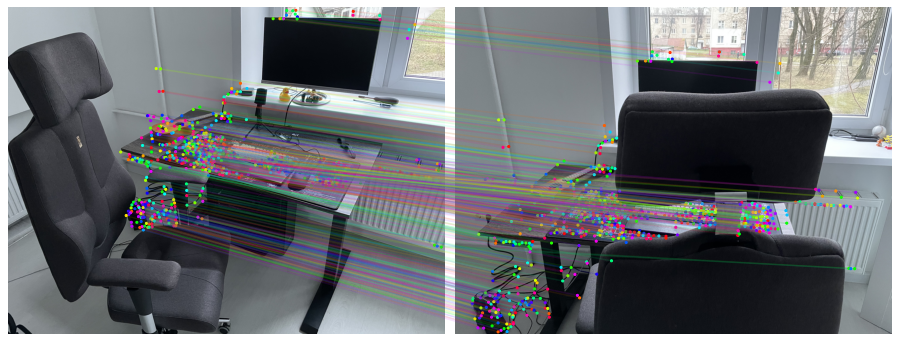

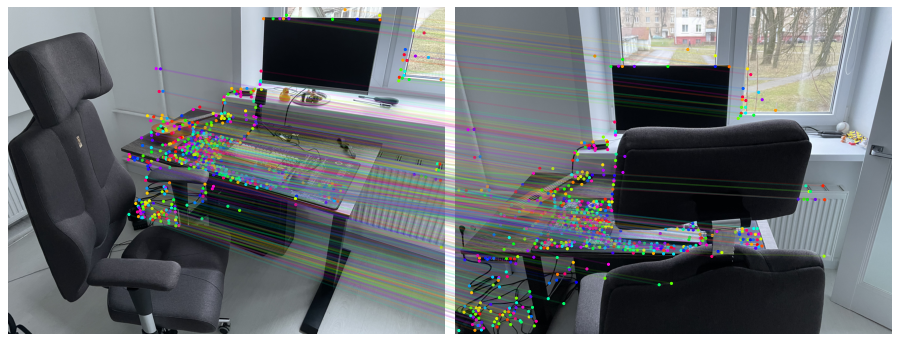

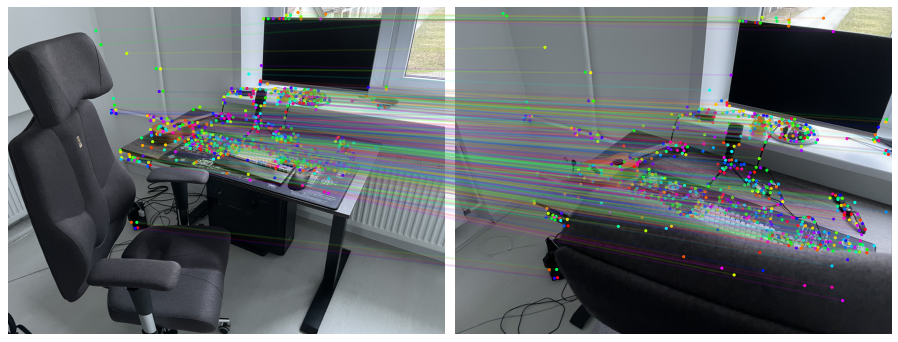

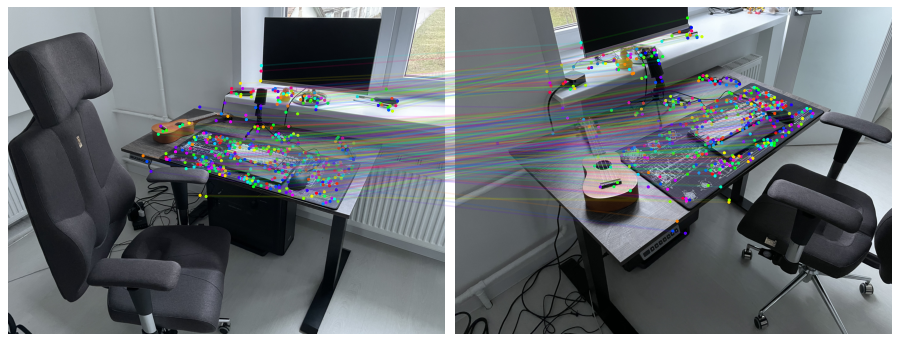

In [219]:
visualization.visualize_match(results, dataset, n=1, seed=2, output_path=outputs, dataset_name=dataset_name)